In [1]:
import pycrfsuite

In [2]:
from collections import Counter
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
from _chain import Chain
from _pytorch_chain_loss import belief_propagation_cross_entropy_loss

### Define Binary HMM 

In [5]:
def f_phi(x1, x2):
#     p = np.array([
#     [0.58, 0.42],
#     [0.42, 0.58]])
#     return p[x1, x2]
    b = [-0.32, 0.4]
    return np.round(exp(b[x2] * (x1 - 0.5)), 2)

In [6]:
def f_psi(x1, x2):
#     p = np.array([
#     [0.62, 0.38],
#     [0.34, 0.66]])
#     return p[x1, x2]
    j = 1
    return np.round(exp(j * (x1 - 0.5) * (x2 - 0.5)), 2)

In [7]:
phi = f_phi
psi = f_psi

In [8]:
T = 50 # chain length

In [9]:
chain = Chain(length=T, phi=phi, psi=psi, possible_values=[0, 1])

### Create Random Trainset

In [10]:
possible_values = [0, 1]

In [11]:
N = 1000

In [12]:
%%time 

X_dataset = []
y_dataset= []

for i in range(N):
    x = np.random.rand(T)
    x_binary = 1 * (x > 0.5)
    
    chain.update_observed(x_binary)
    y = chain.get_max_apostriori_beliefs()

    X_dataset.append(x_binary)
    y_dataset.append(y)

CPU times: user 5.72 s, sys: 21.4 ms, total: 5.74 s
Wall time: 5.74 s


In [13]:
# turn to numpy arrays
X_dataset = np.array([np.array(xi) for xi in X_dataset])
y_dataset = np.array([np.array(yi) for yi in y_dataset])

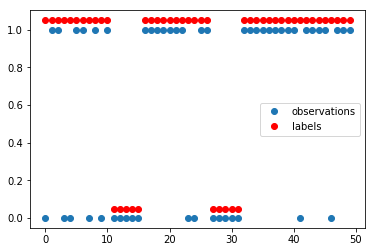

In [14]:
plot(X_dataset[0], 'o')
plot(y_dataset[0] + 0.05, 'ro')
legend(['observations', 'labels'])

### Train Dummy Model (predicts y = x)

#### Train-Test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2)

#### Evaluate 

In [16]:
y_pred = X_test

In [17]:
labels = {0 : 0, 1: 1}

predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.62      0.79      0.69      3903
           1       0.84      0.69      0.75      6097

   micro avg       0.73      0.73      0.73     10000
   macro avg       0.73      0.74      0.72     10000
weighted avg       0.75      0.73      0.73     10000



### Train CRF

In [18]:
def extract_features(x):
    features = [
        'x.current=' + str(x)
    ]
    return features

In [19]:
def extract_labels(y):
    return str(y)

#### Preprocess Dataset

In [20]:
X = []
y = []

for xseq, yseq in zip(X_dataset, y_dataset):
    X_features = [extract_features(x_i) for x_i in xseq]
    y_labels = [extract_labels(y_i) for y_i in yseq]
    
    X.append(X_features)
    y.append(y_labels)

#### Train-Test split 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Train 

In [22]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [23]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0,
    c2=0,  # regulate this up to 1 if needed
    max_iterations=5000,
    all_possible_transitions=True,
    all_possible_states=True
)
crf.fit(X_train, y_train)

CPU times: user 193 ms, sys: 4.04 ms, total: 197 ms
Wall time: 197 ms


In [24]:
y_pred = crf.predict(X_test)

In [25]:
labels = list(crf.classes_)
labels

['1', '0']

In [26]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000      3812
           1      1.000     1.000     1.000      6188

   micro avg      1.000     1.000     1.000     10000
   macro avg      1.000     1.000     1.000     10000
weighted avg      1.000     1.000     1.000     10000



In [27]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

Transitions:
1      -> 1       342.563882
0      -> 0       302.655716
1      -> 0       -321.898039
0      -> 1       -323.321560


In [28]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("States:")
print_state_features(Counter(crf.state_features_).most_common(30))

States:
231.897001 1        x.current=1
222.593344 0        x.current=0
-222.593344 1        x.current=0
-231.897001 0        x.current=1


### Training FC NN 

#### Define 

In [29]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [30]:
n_epochs = 200
batch_size, D_in, D_hidden, D_out = 256, T, T, T

In [31]:
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(D_hidden, D_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(D_hidden, D_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(D_hidden, D_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(D_hidden, D_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(D_hidden, D_out),
          torch.nn.Sigmoid()
        )

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [33]:
print('Network has {} parameters, notice your training set size!'.format(count_parameters(model)))

Network has 15300 parameters, notice your training set size!


In [34]:
from torch.utils.data import Dataset

class ChainDataset(Dataset):
    
    def __init__(self, X, y, flatten=True):
        self._X = X
        self._y = y

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        sample = {
            'X': torch.from_numpy(self._X[idx]).float(),
            'y': torch.from_numpy(self._y[idx]).float()  
        }
        return sample

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2)

In [36]:
trainset = ChainDataset(X_train, y_train)
testset = ChainDataset(X_test, y_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True, num_workers=2)

#### Train 

In [41]:
model.train()
learning_curve = []

for epoch in range(1, n_epochs + 1):
    
    for batch in trainloader:
        
        X_batch, y_batch = Variable(batch['X']), Variable(batch['y'])
        model.zero_grad()
        
        y_pred = model(X_batch)
        loss = F.binary_cross_entropy(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        valid = next(iter(validloader))
        X_valid, y_valid = Variable(valid['X']), Variable(valid['y']) 
        y_pred_valid = model(X_valid)
        loss_valid = F.binary_cross_entropy(y_pred_valid, y_valid)
        
        print('epoch {}:: loss = {}, validation loss = {}'. format(epoch, loss, loss_valid))
        learning_curve.append((loss, loss_valid))

epoch 10:: loss = 0.6386070847511292, validation loss = 0.6420876383781433
epoch 20:: loss = 0.5417201519012451, validation loss = 0.5618528723716736
epoch 30:: loss = 0.4871368110179901, validation loss = 0.543056070804596
epoch 40:: loss = 0.4642716944217682, validation loss = 0.5319937467575073
epoch 50:: loss = 0.426086962223053, validation loss = 0.5039685964584351
epoch 60:: loss = 0.3601410984992981, validation loss = 0.4992850124835968
epoch 70:: loss = 0.3880794942378998, validation loss = 0.5033949017524719
epoch 80:: loss = 0.3555992841720581, validation loss = 0.5435436964035034
epoch 90:: loss = 0.30707454681396484, validation loss = 0.5567889213562012
epoch 100:: loss = 0.3293323814868927, validation loss = 0.5889564156532288
epoch 110:: loss = 0.2705768644809723, validation loss = 0.620589554309845
epoch 120:: loss = 0.26991507411003113, validation loss = 0.6075847148895264
epoch 130:: loss = 0.2661522924900055, validation loss = 0.6937414407730103
epoch 140:: loss = 0.2

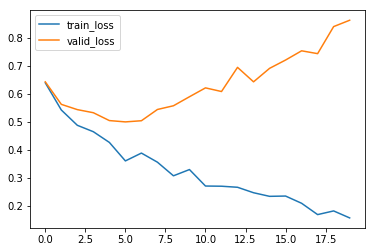

In [42]:
plot([tr_loss for tr_loss, valid_loss in learning_curve]);
plot([valid_loss for tr_loss, valid_loss in learning_curve]);
legend(['train_loss', 'valid_loss'])

#### Evaluate 

In [43]:
model.eval()

Sequential(
  (0): Linear(in_features=50, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): ReLU()
  (6): Linear(in_features=50, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=50, bias=True)
  (9): ReLU()
  (10): Linear(in_features=50, out_features=50, bias=True)
  (11): Sigmoid()
)

In [44]:
y_pred = np.array([model(torch.from_numpy(xseq).float()).detach().numpy() for xseq in X_test])

In [45]:
y_pred = 1 * (y_pred > 0.5)

In [46]:
labels = {0 : 0, 1: 1}

predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.77      0.72      0.74      4579
           1       0.77      0.82      0.79      5421

   micro avg       0.77      0.77      0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



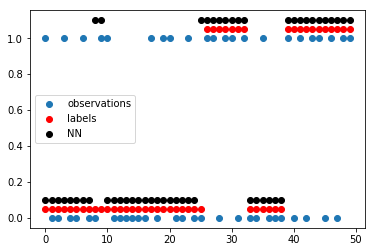

In [47]:
i = np.random.randint(200)
plot(X_test[i], 'o')
plot(y_test[i] + 0.05, 'ro')
plot(y_pred[i] + 0.1, 'ko')
legend(['observations', 'labels', 'NN'])

###  Training MPNN based model

In [37]:
n_epochs = 50
batch_size, D_in, D_hidden = 256, T, T
D_out = 3 # J is one parameter, b is 2

In [38]:
energy_model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(D_hidden, D_out),
          torch.nn.ReLU()
        )

optimizer = optim.Adam(energy_model.parameters(), lr=0.005)

In [ ]:
energy_model.train()
learning_curve = []

for epoch in range(1, n_epochs + 1):
    
    for batch in trainloader:
        X_batch, y_batch = Variable(batch['X']), Variable(batch['y'])
        energy_model.zero_grad()
        
        energy = energy_model(X_batch)
        j, b = energy[:, 0], energy[:, 1:]
        print(j.mean(0).detach(), b.mean(0).detach())
        loss = belief_propagation_cross_entropy_loss(j, b, X_batch, y_batch)
        print("ACTUAL::", belief_propagation_cross_entropy_loss(j_real, b_real, X_batch, y_batch))
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0:
            valid = next(iter(validloader))
            X_valid, y_valid = Variable(valid['X']), Variable(valid['y']) 
            energy_valid = energy_model(X_valid)
            j_valid, b_valid = energy_valid[:, 0], energy_valid[:, 1:]
            loss_valid = belief_propagation_cross_entropy_loss(j_valid, b_valid, X_valid, y_valid)

            print('epoch {}:: loss = {}, validation loss = {}'. format(epoch, loss, loss_valid))
            learning_curve.append((loss, loss_valid))

### Evaluate 

In [590]:
energy_model.eval()

Sequential(
  (0): Linear(in_features=50, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=3, bias=True)
  (3): ReLU()
)

In [692]:
energy_pred = energy_model(torch.from_numpy(X_test).float()).detach().numpy()

In [693]:
j = energy_pred[:, 0]
b = energy_pred[:, 1:]

In [694]:
y_pred = belief_propagation_cross_entropy_loss(j, b, X_test, torch.Tensor(y_test), train=False)

In [ ]:
y_pred

In [ ]:
labels = {0 : 0, 1: 1}

predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

##### backout of efficient implementation 

In [585]:
def belief_propagation_cross_entropy_loss_efficient(j, b, observations, labels):
    batch_size = labels.size()[0]
    len_ = T # length of chain
    
    loss = 0
    
    for b_idx in range(batch_size):

        values = torch.Tensor([0, 1]) - 0.5
        pairs = torch.mul(values.view(-1, 2).t(), values)
        unit_msg = torch.ones([2, 1])
        
        forward_messages = torch.Tensor()
        msg_left = unit_msg # no information traveling left to x1
        # forward pass    
        for i in range(0, len_ - 1):
            
            phi = torch.exp(torch.mul(b[b_idx][int(observations[b_idx][i])], values))
            psi = torch.exp(torch.mul(j[b_idx], pairs))
  
            step1 = torch.mul(phi, msg_left.t())
            step2 = torch.mul(step1, psi)
            step3, _ = torch.max(step2, dim=1)

            msg = step3.view(-1 ,1)
            msg_with_data_term = torch.mul(phi.view(-1, 1), msg_left)
            
            forward_messages = torch.cat((forward_messages, msg_with_data_term), dim=1)    
            msg_left = msg
        
        msg_with_data_term = torch.mul(phi.view(-1, 1), msg_left)
        forward_messages = torch.cat((forward_messages, msg_with_data_term), dim=1) # last message
        
        backward_messages = unit_msg
        msg_right = unit_msg # no information traveling right to x_n
        # backward pass    
        for i in range(len_ - 1, 0, -1):

            phi = torch.exp(torch.mul(b[b_idx][int(observations[b_idx][i])], values))
            psi = torch.exp(torch.mul(j[b_idx], pairs))
            step1 = torch.mul(phi, msg_right.t())
            step2 = torch.mul(step1, psi)
            step3, _ = torch.max(step2, dim=1)

            msg = step3.view(-1 ,1)
            backward_messages = torch.cat((msg, backward_messages), dim=1)    
            msg_right = msg

        # calculate beliefs
        messages = torch.mul(forward_messages, backward_messages)

        norm_ = torch.norm(messages, p=1, dim=0)  # L1 norm
        beliefs_norm = torch.div(messages, norm_)
        beliefs_softmax = torch.softmax(beliefs_norm, dim=0)
        loss += F.binary_cross_entropy(beliefs_softmax[1, :], labels[b_idx])
        
    return loss #, beliefs_norm[1, :] > 0.5

### Sanity - check that we can reach loss zero

In [51]:
ind = np.random.randint(1000)
j = np.array([1])
b = np.array([-0.32, 0.4])
labels = y_dataset[ind]
observations = X_dataset[ind]

In [52]:
j.shape, b.shape, labels.shape, observations.shape

((1,), (2,), (50,), (50,))

In [53]:
# add batch dimension

In [54]:
j = np.expand_dims(j, axis=0)
b = np.expand_dims(b, axis=0)
labels = np.expand_dims(labels, axis=0)
observations = np.expand_dims(observations, axis=0)

In [55]:
# move to tensors

In [56]:
import torch

In [57]:
j = torch.Tensor(j)
b = torch.Tensor(b)
labels = torch.Tensor(labels)
observations = torch.Tensor(observations)

In [58]:
%%time
loss = belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T)
beliefs = belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T, train=False)[-1]

CPU times: user 15.8 ms, sys: 1.55 ms, total: 17.3 ms
Wall time: 16.1 ms


In [59]:
loss, torch.eq(labels, beliefs.float()), torch.all(torch.eq(labels, beliefs.float()))

(tensor(0.5671),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1]], dtype=torch.uint8),
 tensor(1, dtype=torch.uint8))

In [60]:
labels

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [61]:
beliefs

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], dtype=torch.uint8)

#### Plot loss as a function of b

In [81]:
res = {'b0': [], 'b1': [], 'loss': []}

for i_sample in range(1000):
    labels = y_dataset[1]
    observations = X_dataset[1]
    j = 1  
    b_base = 2 * (np.random.rand(2) - 0.5)
  
    j = np.expand_dims(j, axis=0)
    b = np.expand_dims(b_base, axis=0)
    labels = np.expand_dims(labels, axis=0)
    observations = np.expand_dims(observations, axis=0)
    
    j = torch.Tensor(j)
    b = torch.Tensor(b)
    labels = torch.Tensor(labels)
    observations = torch.Tensor(observations)
    
    res['b0'].append(b_base[0])
    res['b1'].append(b_base[1])
    res['loss'].append(float(belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T)))

# make sure real values are on the graph
b_base = [-0.32, 0.4]
b = np.expand_dims(b_base, axis=0)
b = torch.Tensor(b)
res['b0'].append(b_base[0])
res['b1'].append(b_base[1])
res['loss'].append(float(belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T)))

In [82]:
import pandas as pd

In [83]:
df = pd.DataFrame(res)

In [84]:
import plotly.express as px

fig = px.scatter_3d(df, x="b0", y="b1", z="loss", color="loss",
                 hover_data=['b0', 'b1', 'loss'])
fig.write_html('loss_vs_data_term.html', auto_open=True)

#### Doing the same as a function of all

In [86]:
res = {'b0': [], 'b1': [], 'j': [], 'loss': []}

for i_sample in range(1000):
    labels = y_dataset[1]
    observations = X_dataset[1]
    
    j_val = np.random.rand() + 0.5
    b_base = 2 * (np.random.rand(2) - 0.5)
    
    b = np.expand_dims(b_base, axis=0)
    j = np.expand_dims(j_val, axis=0)
    labels = np.expand_dims(labels, axis=0)
    observations = np.expand_dims(observations, axis=0)
    
    j = torch.Tensor(j)
    b = torch.Tensor(b)
    labels = torch.Tensor(labels)
    observations = torch.Tensor(observations)
    
    res['b0'].append(b_base[0])
    res['b1'].append(b_base[1])
    res['j'].append(j_val)
    res['loss'].append(float(belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T)))

In [87]:
df = pd.DataFrame(res)

In [88]:
df

,b0,b1,j,loss
0,0.090164,-0.328447,0.665573,0.811473
1,0.294405,0.163597,1.357335,0.575703
2,0.768406,-0.701573,0.826904,0.778174
3,0.640219,-0.255443,1.000309,0.670103
4,-0.166367,-0.980200,0.997439,0.924915
5,-0.254867,0.557632,0.574188,0.608870
6,-0.518469,0.773864,1.273343,0.547626
7,0.117375,0.713426,1.154906,0.563393
8,0.843897,0.160723,0.730916,0.604344
9,-0.599323,0.096696,1.267062,0.865352


In [89]:
import plotly.express as px
fig = px.scatter_3d(df, x="b0", y="b1", z="j", color="loss",
                 hover_data=['b0', 'b1', 'j', 'loss'],
                   )
fig.write_html('loss_vs_all.html', auto_open=True)